In [504]:
import time
import wave
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pyaudio
import librosa
import librosa.display
import realtime_analysis as ra

In [2]:
plt.rcParams["figure.figsize"] = (14, 4)

# record/load audio

In [3]:
RATE = 44100
CHANNELS = 1
SAMPLES_PER_BUFFER = 1024
duration = 8
total_length = int(8*RATE)
print("buffer length:", SAMPLES_PER_BUFFER/RATE)

x = np.zeros(total_length, dtype=np.float32)
t = librosa.samples_to_time(np.arange(x.shape[0]), sr=RATE)
x_index = 0
def input_callback(in_data, frame_count, time_info, status):
    global x_index
    
    if x_index+frame_count > x.shape[0]:
        return None, pyaudio.paComplete

    audio_data = np.frombuffer(in_data, dtype=np.float32)
    x[x_index:x_index+frame_count] = audio_data
    x_index += frame_count

    return in_data, pyaudio.paContinue

print("recording...")

p = pyaudio.PyAudio()

input_stream = p.open(format=pyaudio.paFloat32,
                      channels=CHANNELS,
                      rate=RATE,
                      input=True,
                      output=False,
                      frames_per_buffer=SAMPLES_PER_BUFFER,
                      stream_callback=input_callback)
input_stream.start_stream()

while input_stream.is_active():
    time.sleep(0.1)

input_stream.stop_stream()
input_stream.close()

p.terminate()

print("finish!")

buffer length: 0.023219954648526078
recording...
finish!


In [517]:
with wave.open("test.wav", "wb") as file:
    for _ in ra.pipe(ra.slice(x), ra.save(file, RATE)):
        pass

In [519]:
with wave.open("test.wav", "rb") as file:
    print(file.getparams())
    x = np.concatenate(list(ra.load(file, RATE)))

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=353280, comptype='NONE', compname='not compressed')


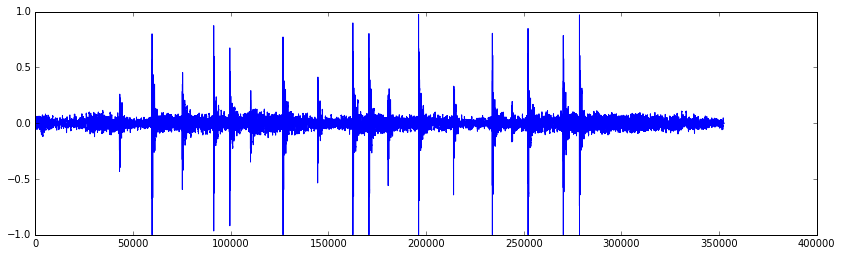

In [520]:
plt.plot(x)
# librosa.display.waveplot(x, RATE)

# spectrum

In [5]:
WIN_LENGTH = 1024
HOP_LENGTH = 512
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039


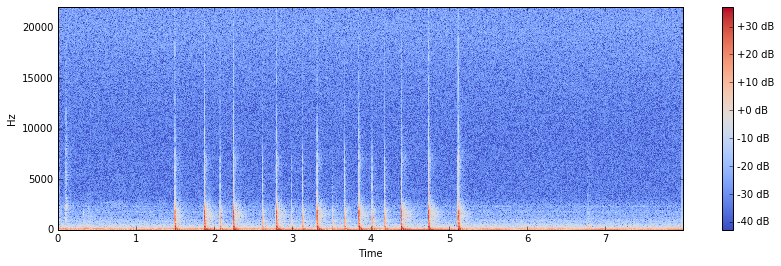

In [6]:
X = librosa.stft(x, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH, center=False)
Xdb = librosa.amplitude_to_db(abs(X))
t_frames = librosa.frames_to_time(np.arange(X.shape[1]), sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

librosa.display.specshow(Xdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

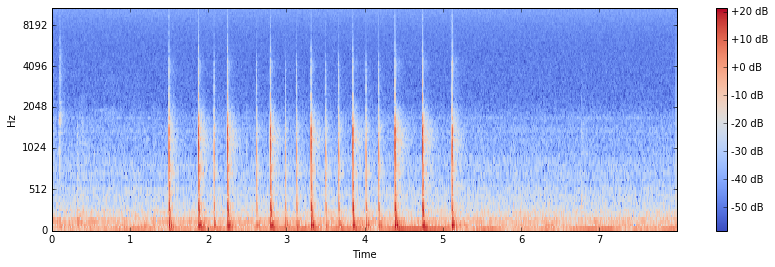

In [7]:
M = librosa.feature.melspectrogram(S=abs(X)**2, sr=RATE, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)
Mdb = librosa.power_to_db(M)

librosa.display.specshow(Mdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")

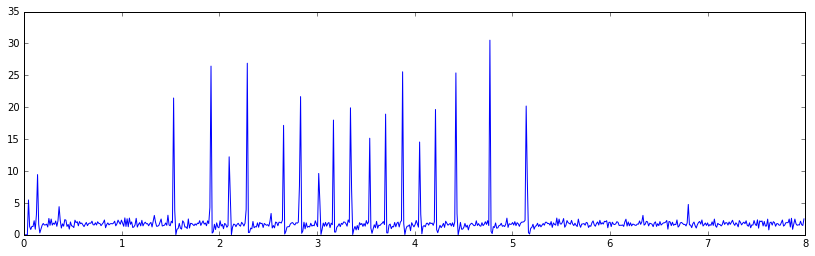

In [8]:
onset_env = librosa.onset.onset_strength(S=Mdb, sr=RATE)
plt.plot(t_frames, onset_env)

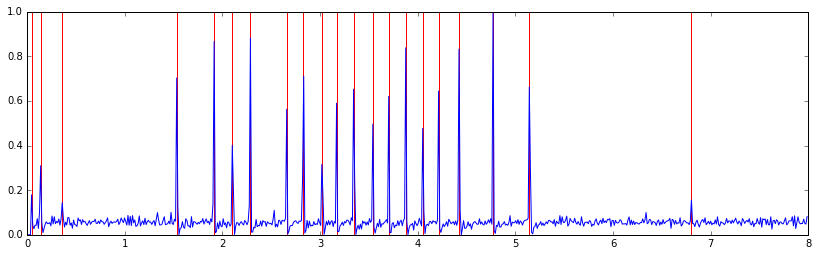

In [9]:
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
onset_times = librosa.frames_to_time(onset_frames, sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

plt.plot(t_frames, onset_env)
plt.vlines(onset_times, ymin=0, ymax=1, color="r")

In [11]:
onset_block = []
for index in onset_samples:
    onset_waveform = x[index-HOP_LENGTH*2:index]
    onset_block.append(onset_waveform)
#     plt.plot(onset_waveform)
#     plt.show()

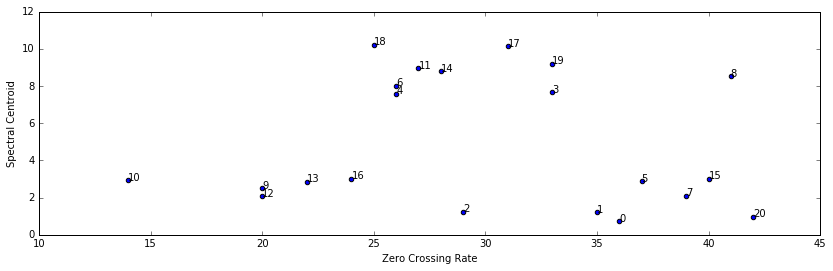

In [12]:
zcr = np.array([librosa.zero_crossings(xs).sum() for xs in onset_block])
cen = np.array([scipy.linalg.norm(xs) for xs in onset_block])

plt.scatter(zcr, cen)
ax = plt.gca()
for i in range(len(zcr)):
    ax.annotate(i, (zcr[i], cen[i]))
plt.xlabel("Zero Crossing Rate")
plt.ylabel("Spectral Centroid")

# realtime

In [516]:
import imp
imp.reload(ra)

<module 'realtime_analysis' from '/home/qislab-presentation/Documents/knock/realtime_analysis.py'>

In [5]:
WIN_LENGTH = 512*4
HOP_LENGTH = 512
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039


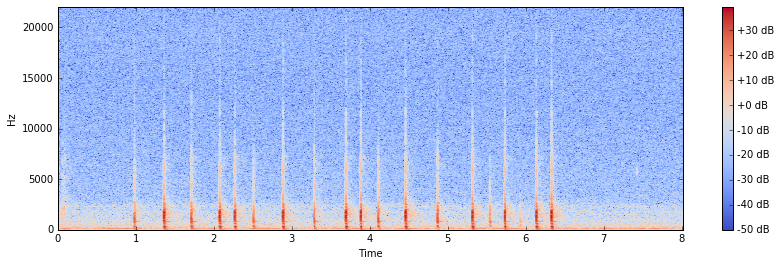

In [6]:
spec_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                    ra.frame(WIN_LENGTH, HOP_LENGTH),
                    ra.power_spectrum(RATE, WIN_LENGTH),
                    ra.DataNode(ra.power2db))
spec = np.stack(list(spec_node)).T

librosa.display.specshow(spec, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

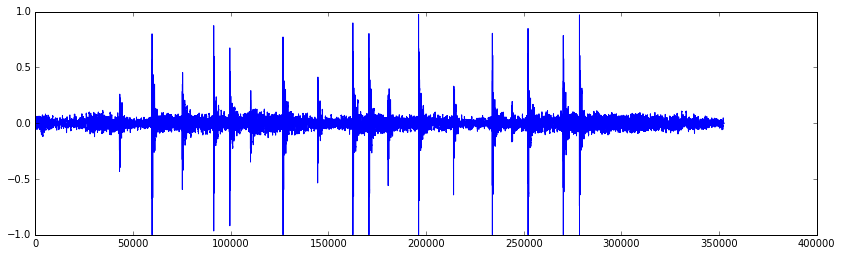

In [98]:
plt.plot(x)

1.138662838632788


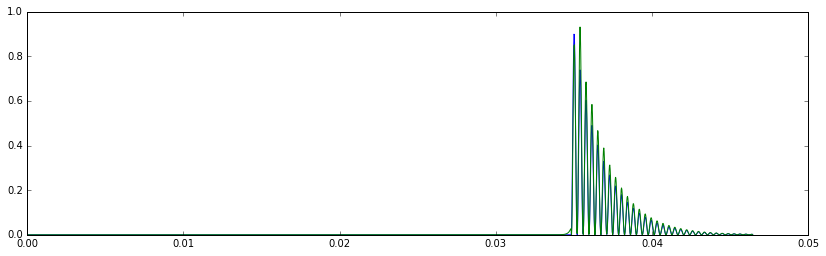

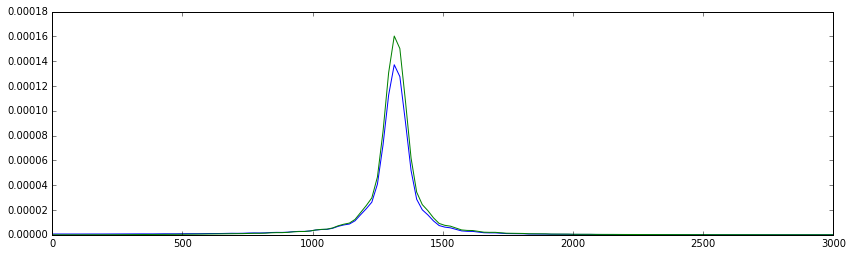

(1320.1176869007147, 0.0010640563832640558)

In [443]:
def pulse(freq, thalf, t0=0):
    t = np.linspace(0, WIN_LENGTH/RATE, WIN_LENGTH) - t0
    pulse0 = np.sin(t*freq*2*np.pi) * 2**(-t/thalf/2)
    pulse0[t<0] = 0
    return pulse0

# def Afilter(signal):
#     return np.fft.irfft(ra.get_A_weight(RATE, WIN_LENGTH)**0.5 * np.fft.rfft(signal))

t_win = np.linspace(0, WIN_LENGTH/RATE, WIN_LENGTH)
f_win = np.linspace(0, RATE/2, WIN_LENGTH//2+1)
pulse0 = pulse(1319, 0.00130, (WIN_LENGTH - HOP_LENGTH)/RATE)
pulse0A = np.fft.irfft(ra.get_A_weight(RATE, WIN_LENGTH)**0.5 * np.fft.rfft(pulse0))
print((pulse0A**2).sum() / (pulse0**2).sum())
plt.plot(t_win, pulse0**2)
plt.plot(t_win, pulse0A**2)
plt.show()
plt.plot(f_win, np.abs(np.fft.rfft(pulse0))**2 * 2/WIN_LENGTH/RATE)
plt.plot(f_win, np.abs(np.fft.rfft(pulse0A))**2 * 2/WIN_LENGTH/RATE)
plt.xlim((0, 3000))
plt.show()

def analyze_pulse(pulse):
    weight = ra.get_A_weight(RATE, WIN_LENGTH)
    J = np.abs(np.fft.rfft(pulse))**2 * (2/WIN_LENGTH/RATE)
    f = np.arange(WIN_LENGTH//2+1) * (RATE/WIN_LENGTH)
    E0 = (weight * J).sum()
    freq = (weight * J * f).sum() / E0
    # thalf = E0 * np.log(2) * 2
    return freq, E0

# analyze_pulse(block)
analyze_pulse(pulse0)

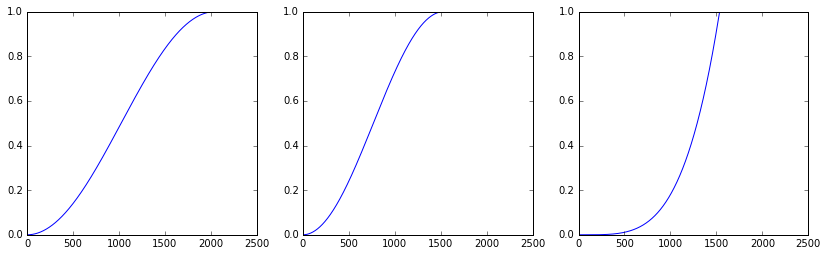

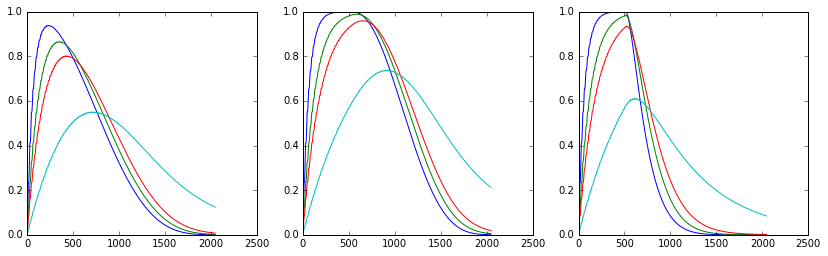

In [460]:
hann_window = np.sin(np.linspace(0, np.pi, WIN_LENGTH))**2
# hann_window /= (hann_window**2).mean()**0.5

halfhann_window = np.sin(np.linspace(0, np.pi/2, WIN_LENGTH))**2
# halfhann_window /= (halfhann_window**2).mean()**0.5

halftukey_window = np.sin(np.linspace(0, np.pi/2 * WIN_LENGTH/(WIN_LENGTH-HOP_LENGTH), WIN_LENGTH))**2
halftukey_window[-HOP_LENGTH:] = 1
# halftukey_window /= (halftukey_window**2).mean()**0.5

polytail_window = np.linspace(0, WIN_LENGTH/(WIN_LENGTH-HOP_LENGTH), WIN_LENGTH)**4
polytail_window[-HOP_LENGTH:] = 1
# polytail_window /= (polytail_window**2).mean()**0.5

plt.subplot(131)
plt.plot(halfhann_window)
plt.subplot(132)
plt.plot(halftukey_window)
plt.subplot(133)
plt.plot(polytail_window)
plt.show()

def catch_pulse(window, freq, thalf):
    signal = pulse(freq, thalf)**2
    return scipy.signal.convolve(window[::-1]**2, signal)[:WIN_LENGTH] / signal.sum()

plt.subplot(131)
plt.plot(catch_pulse(halfhann_window, 1300, 0.001))
plt.plot(catch_pulse(halfhann_window, 1300, 0.002))
plt.plot(catch_pulse(halfhann_window, 1300, 0.003))
plt.plot(catch_pulse(halfhann_window, 1300, 0.01))
plt.subplot(132)
plt.plot(catch_pulse(halftukey_window, 1300, 0.001))
plt.plot(catch_pulse(halftukey_window, 1300, 0.002))
plt.plot(catch_pulse(halftukey_window, 1300, 0.003))
plt.plot(catch_pulse(halftukey_window, 1300, 0.01))
plt.subplot(133)
plt.plot(catch_pulse(polytail_window, 1300, 0.001))
plt.plot(catch_pulse(polytail_window, 1300, 0.002))
plt.plot(catch_pulse(polytail_window, 1300, 0.003))
plt.plot(catch_pulse(polytail_window, 1300, 0.01))
plt.show()


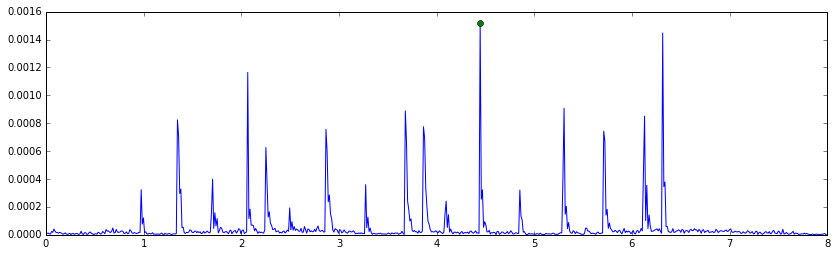

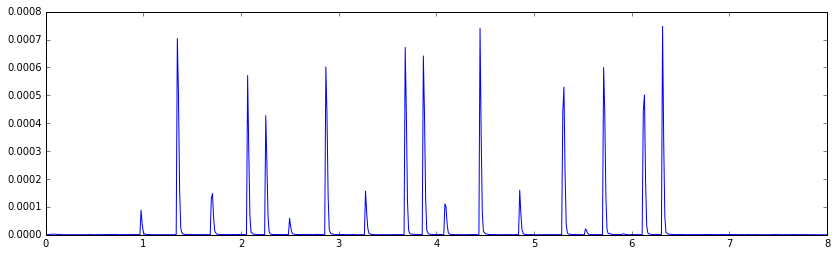

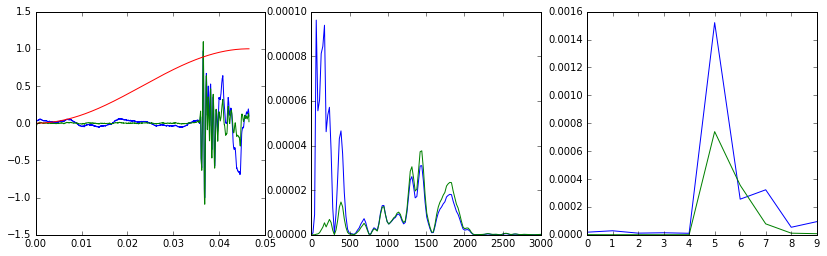

(1359.243788833535, 0.0008841746281026735)


In [493]:
Dt = HOP_LENGTH/RATE
t = np.arange(power.shape[0]) * Dt

power_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                     ra.DataNode(lambda x: (x**2).sum() * (1/RATE)))
power = np.array(list(power_node))
max_power_index = np.argmax(power)
plt.plot(t, power)
plt.plot(t[max_power_index], power[max_power_index], "o")
plt.show()

window = halfhann_window
power2_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                      ra.frame(WIN_LENGTH, HOP_LENGTH),
                      ra.power_spectrum(RATE, WIN_LENGTH, windowing=window, weighting=True),
                      ra.DataNode(lambda x: x.sum()))

power2 = np.array(list(power2_node))
plt.plot(t, power2)
plt.show()

max_block = x[max_power_index*HOP_LENGTH+HOP_LENGTH-WIN_LENGTH:max_power_index*HOP_LENGTH+HOP_LENGTH]
max_blockA = np.fft.irfft(ra.get_A_weight(RATE, WIN_LENGTH)**0.5 * np.fft.rfft(max_block))
plt.subplot(131)
plt.plot(t_win, max_block)
plt.plot(t_win, max_blockA)
plt.plot(t_win, window)

plt.subplot(132)
plt.plot(f_win, np.abs(np.fft.rfft(max_block))**2 * 2/WIN_LENGTH/RATE)
plt.plot(f_win, np.abs(np.fft.rfft(max_blockA))**2 * 2/WIN_LENGTH/RATE)
plt.xlim((0, 3000))

plt.subplot(133)
plt.plot(power[max_power_index-5:max_power_index+5])
plt.plot(power2[max_power_index-5:max_power_index+5])
plt.show()

print(analyze_pulse(max_block))


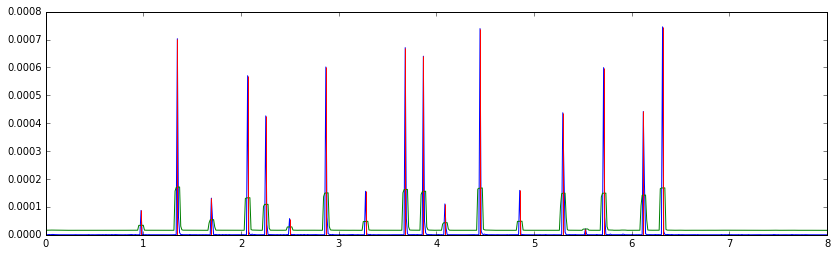

In [489]:
PRE_MAX = int(0.03 / Dt)
POST_MAX = int(0.03 / Dt)
PRE_AVG = int(0.03 / Dt)
POST_AVG = int(0.03 / Dt)
WAIT = int(0.03 / Dt)
DELTA = 0.0008/100*2

peak_node = ra.pick_peak(pre_max=PRE_MAX, post_max=POST_MAX,
                         pre_avg=PRE_AVG, post_avg=POST_AVG,
                         wait=WAIT, delta=DELTA)

envelope = []
onset_node = ra.pipe(ra.slice(x, HOP_LENGTH),
                     ra.frame(WIN_LENGTH, HOP_LENGTH),
                     ra.power_spectrum(RATE, WIN_LENGTH, windowing=halfhann_window, weighting=True),
                     ra.onset_strength(1, 1),
                     ra.branch(ra.DataNode(envelope.append)),
                     peak_node)

onset = np.array(list(onset_node))
envelope = np.array(envelope)
onset_indices = (np.arange(envelope.shape[0]) - peak_node.delay)[onset]

avg_threshold = scipy.ndimage.uniform_filter1d(envelope, 5) + DELTA
plt.plot(t, envelope)
plt.plot(t, avg_threshold)
plt.vlines(t[onset_indices], ymin=0, ymax=envelope[onset_indices], color="r", zorder=3)
# plt.ylim((0, 3))

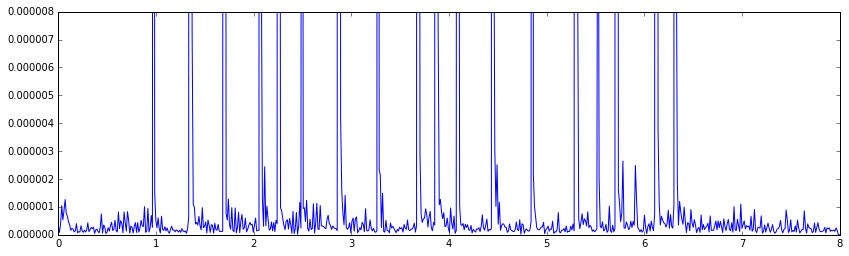

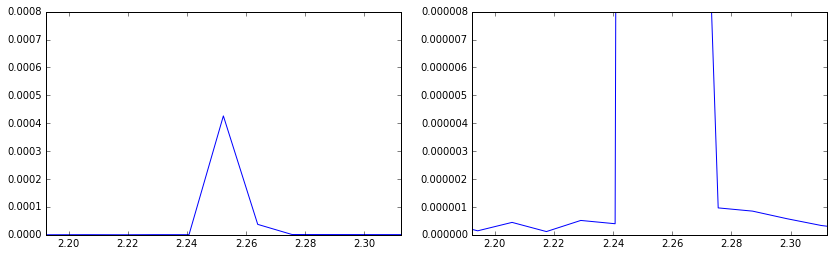

In [488]:
plt.plot(t, envelope)
plt.ylim((0, 0.0008/100))
plt.show()
plt.subplot(121)
plt.plot(t, envelope)
plt.xlim((t[onset_indices[2]]-0.06, t[onset_indices[2]]+0.06))
plt.subplot(122)
plt.plot(t, envelope)
plt.xlim((t[onset_indices[2]]-0.06, t[onset_indices[2]]+0.06))
plt.ylim((0, 0.0008/100))
plt.show()

6.61949540516598e-07 2.7540814501718677e-07


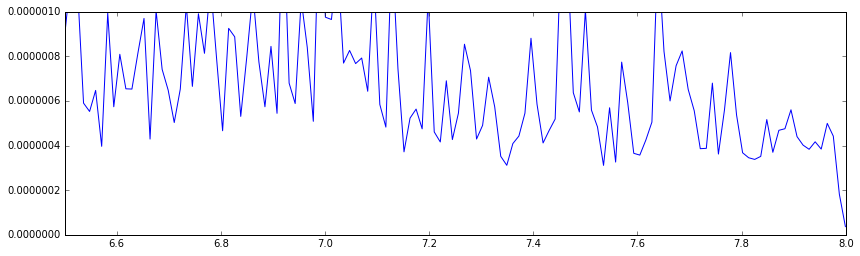

2.7434382331207744e-07 2.0504711592582098e-07


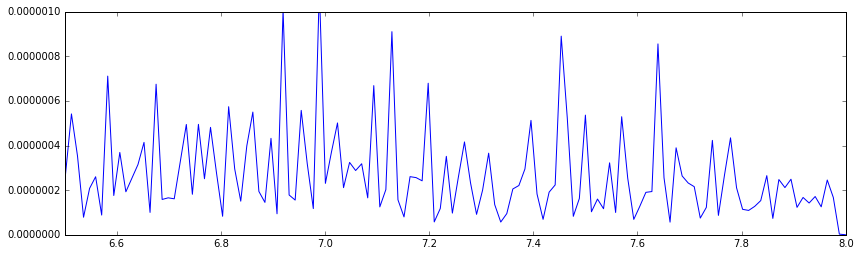

In [502]:
print(power2[(t>6.5) & (t<8)].mean(), power2[(t>6.5) & (t<8)].std())
plt.plot(t, power2)
plt.xlim((6.5, 8))
plt.ylim((0, 1e-6))
plt.show()

print(envelope[(t>6.5) & (t<8)].mean(), envelope[(t>6.5) & (t<8)].std())
plt.plot(t, envelope)
plt.xlim((6.5, 8))
plt.ylim((0, 1e-6))
plt.show()
